In [6]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import json
import h5py
import os

def load_data(path):
    """
    Load h5 file and convert it to a pandas DataFrame.

    Parameters:
        path (str): Path to the .mat dataset file.
    Returns:
        pd.DataFrame: DataFrame containing the dataset.
    """

    with h5py.File(path, "r") as f:
        key = list(f.keys())[0]
        raw = f[key][:]  # uint8 array

    # Convert to text
    text = raw.tobytes().decode("utf-8")

    # Load as json
    data_json = json.loads(text)

    # Extract relevant fields
    data = {
        "Time": data_json["Time"],
        "I": data_json["I"],
        "U": data_json["U"],
        "Line": data_json["Line"],
        "Capacity": data_json["Ah"]
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)   

    return df 

def process_states(data):
    """
    Process the battery dataset and assign operational states based on the 'Line' column.

    Parameters:
        path (str): Path to the .mat dataset file.

    Returns:
        dict: Dataset including the computed 'status' column.
    """

    # Define operational states based on 'Line' value ranges
    data["status"] = np.where(data["Line"] <= 13, "Rest", "")
    data["status"] = np.where((data["Line"] > 13) & (data["Line"] < 15), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 14) & (data["Line"] < 16), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 15) & (data["Line"] < 17), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 16) & (data["Line"] < 19), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 19) & (data["Line"] < 21), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 20) & (data["Line"] < 22), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 21) & (data["Line"] < 23), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 22) & (data["Line"] < 24), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 23) & (data["Line"] < 26), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 26) & (data["Line"] < 28), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 27) & (data["Line"] < 33), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 32) & (data["Line"] < 34), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 33) & (data["Line"] < 35), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 34) & (data["Line"] < 36), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 35) & (data["Line"] < 37), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 37) & (data["Line"] < 42), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 41) & (data["Line"] < 43), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 42) & (data["Line"] < 44), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 43) & (data["Line"] < 49), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 48) & (data["Line"] < 50), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 49) & (data["Line"] < 51), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 50) & (data["Line"] < 56), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 55), "Other", data["status"])
    return data

def calculate_metrics(data):
    """
    Analyze and compute metrics for each continuous period of a specific battery status.
    Parameters:
        data (dict): cell data 
    Returns:
        pd.DataFrame: DataFrame containing metrics for each status period.
    """

    # Identify changes in status to segment the data
    data["status_change"] = (data["status"] != data["status"].shift()).cumsum()

    # Group by status change segments
    grouped = data.groupby("status_change")

    results = []
    for _, g in grouped:

        subset = g.iloc[3:-3]

        if subset.empty or subset["status"].isna().all():
            continue

        status = subset["status"].iloc[0]
        start_time = subset["Time"].iloc[0]
        end_time = subset["Time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["I"].mean()
        std_current = subset["I"].std()

        avg_tension = subset["U"].mean()
        std_tension = subset["U"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    return pd.DataFrame(results)

def status_to_int(status):
    mapping = {"Rest":0, "CC Discharge":1, "CC Charge":2, "CV Charge":3, "CV Discharge": 4, "Current Pulses":5, "Other":6}
    return mapping.get(status, 4)

In [ ]:
import os

src = "../../../../../../media/mods-pred/Datasets/Data_Munich_h5"
checkups_paths = []

for cell in sorted(os.listdir(src)):
    cell_path = os.path.join(src, cell)
    for file in sorted(os.listdir(cell_path)):
        if "CHECKUP" in file:
            checkups_paths.append(os.path.join(cell_path, file))

all_cycles = []

df_test = load_data(checkups_paths[0])
df_test = process_states(df_test)
results = calculate_metrics(df_test)
results

In [ ]:
import os

src = "../../../../../../media/mods-pred/Datasets/Data_Munich_h5"
checkups_paths = []

for cell in sorted(os.listdir(src)):
    cell_path = os.path.join(src, cell)
    for file in sorted(os.listdir(cell_path)):
        if "CHECKUP" in file:
            checkups_paths.append(os.path.join(cell_path, file))

all_cycles = []

for checkup in checkups_paths:
    df = load_data(checkup)
    df = process_states(df)
    results = calculate_metrics(df)

    features = {}
    for status_name, group in results.groupby("status"):
        features[f"{status_name}_avg_current"] = group["avg_current"].mean()
        features[f"{status_name}_std_current"] = group["std_current"].mean()
        features[f"{status_name}_avg_tension"] = group["avg_tension"].mean()
        features[f"{status_name}_std_tension"] = group["std_tension"].mean()
        features[f"{status_name}_duration"] = group["duration"].sum()

    features["SoH"] = max(df["Capacity"]) * 100 / 2.5
    features["cell_id"] = os.path.basename(os.path.dirname(checkup))
    all_cycles.append(features)

dataset = pd.DataFrame(all_cycles).fillna(0)

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

cells = dataset["cell_id"].unique()
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)

train_df = dataset[dataset["cell_id"].isin(train_cells)]
test_df = dataset[dataset["cell_id"].isin(test_cells)]

X_train = train_df.drop(columns=["SoH", "cell_id"])
y_train = train_df["SoH"]
X_test = test_df.drop(columns=["SoH", "cell_id"])
y_test = test_df["SoH"]

# ------------------------
# Regressão Linear
# ------------------------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("=== Regressão Linear ===")
print("R² teste:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
coef = pd.Series(lin_model.coef_, index=X_train.columns)
print("Features mais importantes (RL):")
print(coef.sort_values(key=abs, ascending=False))

# ------------------------
# Random Forest
# ------------------------
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest ===")
print("R² teste:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print("Features mais importantes (RF):")
print(importances.sort_values(ascending=False))

=== Regressão Linear ===
R² teste: -493.3774367715444
MAE: 24.972387610761658
Features mais importantes (RL):
CC Charge_std_current        -255654.488455
CC Charge_avg_current         -10684.464220
CV Charge_avg_tension           8406.660383
CV Discharge_avg_tension       -8095.159448
CV Charge_std_tension          -7994.789904
CV Discharge_std_tension        5273.118386
CC Charge_std_tension           2577.462014
Current Pulses_std_tension     -1735.709586
Rest_std_tension               -1576.064814
CC Charge_avg_tension           1149.279228
CC Discharge_std_current         916.956552
CC Discharge_std_tension        -804.135443
CV Charge_std_current           -688.571035
_avg_tension                     625.598367
CV Charge_avg_current            460.677868
CV Discharge_avg_current        -424.505321
_avg_current                    -379.353377
CV Discharge_std_current        -226.825125
Current Pulses_avg_tension      -200.603088
CC Discharge_avg_current        -154.463502
CC Dischar

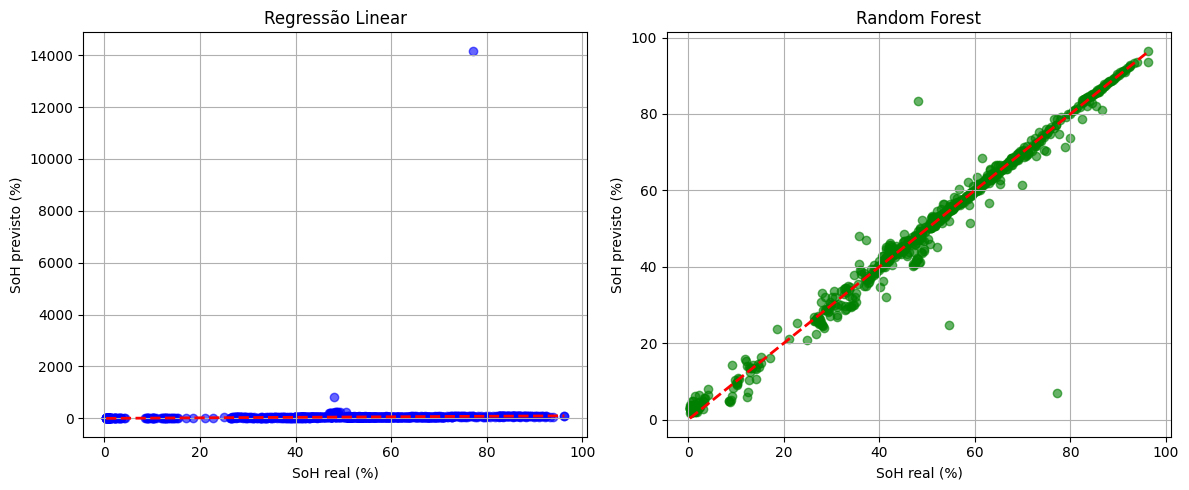

In [ ]:
plt.figure(figsize=(12,5))

# RL
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Regressão Linear")
plt.grid(True)

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Random Forest")
plt.grid(True)

plt.tight_layout()
plt.show()
